In [ ]:
import pandas as pd
import numpy as np 
from numpy import random

data = pd.read_csv('data/result.csv',parse_dates=['time'], index_col=['time'])
train_data = data.loc['2017-07-04 00:00:00':'2017-07-13 03:55:00']
test_data = data.loc['2017-07-13 04:00:00':'2017-07-17 21:15:00']
# data = data[52992:56992]
# data = data.reset_index(drop=True)
data

In [2]:
##Faults:
# 1. Offset Fault: x' = a + x + err
# 2. Gain Fault: x' = Bx+ err
# 3. Stuck at Fault: x' = a
# 4. Out-of-bound: x'<theta1 and x'>theta2

def simulateFault(sensedValues, params):
    end_fault_index = int(len(sensedValues) * 0.8)
    interval = end_fault_index/4
    BMS = []
    classification = []
    
    noise = random.rand(len(sensedValues)) * 0.5
    for i in range(0, len(sensedValues)):
        if i <= interval:
            a = params['constant']
            sign = random.randint(1,3)
            if sign == 1:
                BMS.append(noise[i] + a + sensedValues[i])
            else:
                BMS.append(-noise[i] + a + sensedValues[i])
            classification.append(1)

        elif i > interval and i <= interval*2:
            B = params['coeff']
            sign = random.randint(1,3)
            if sign == 1:
                BMS.append(noise[i] + B * sensedValues[i])
            else:
                BMS.append(-noise[i] + B * sensedValues[i])
            classification.append(1)

        elif i > interval*2 and i<= interval*3:
            a = params['stuck']
            BMS.append(a)
            classification.append(1)
            
        elif i > interval*3 and i<= interval*4:
            type_fault = random.randint(1,3)
            low_bound = params['bounds'][0]
            up_bound = params['bounds'][1]
            if type_fault == 1:
                BMS.append(low_bound-noise[i])
            else:
                BMS.append(up_bound + noise[i])
            classification.append(1)
        else:
            BMS.append(noise[i] + sensedValues[i])
            classification.append(0)

    BMS = np.array(BMS)
    BMS = BMS.round(decimals = 3)
    sensedValues = sensedValues.round(decimals=3)
    return np.array(BMS), np.array(classification)

def simulateSpecificFault(sensedValues, params, value):
    end_fault_index = int(len(sensedValues) * 0.5)
    interval = end_fault_index
    BMS = []
    classification = []
    
    #noise = random.rand(len(sensedValues)) * 0
    
    for i in range(0, len(sensedValues)):
        if i < interval:
            if params == 'constant':
                a = value
                #sign = random.randint(1,3)
                #print('goes here')
                #if sign == 1:
                BMS.append(a + sensedValues[i])
                #else:
                #    BMS.append(noise[i] - a + sensedValues[i])
                classification.append(1)

            elif params == 'gain':
                B = value 
                sign = random.randint(1,3)
                if sign == 1:
                    BMS.append(B * sensedValues[i])
                else:
                    BMS.append(B * sensedValues[i])
                classification.append(1)

            elif params == 'stuck':
                a = value
                BMS.append(a)
                classification.append(1)
            
            elif params == 'bounds':
                half_point = interval/2
                if i < half_point:
                    x = random.randint(273, 289)
                    BMS.append(x)
                else:
                    x = random.randint(303, 323)
                    BMS.append(x)
                classification.append(1)
        else:
            BMS.append(sensedValues[i])
            classification.append(0)

    BMS = np.array(BMS)
    BMS = BMS.round(decimals = 3)
    sensedValues = sensedValues.round(decimals=3)
    return np.array(BMS), np.array(classification)

In [3]:
def sample_vectors(vectors, fault_rate):
    result_x = []
    result_y = []
    end_fault_index1 = int(len(vectors) * 0.5)
    end_fault_index = int(len(vectors) * fault_rate)
    interval = end_fault_index1/4
    for i in range(0, end_fault_index):
        fault = random.randint(0, int(len(vectors)*0.5))
        result_x.append([vectors['lag_1'][fault],vectors['lag_2'][fault],vectors['lag_3'][fault],vectors['lag_4'][fault],vectors['lag_5'][fault],vectors['lag_6'][fault]])
        # if fault <= interval:
        #     result_y.append(1)

        # elif fault > interval and fault <= interval*2:
        #     result_y.append(2)

        # elif fault > interval*2 and fault<= interval*3:
        #     result_y.append(3)
            
        # elif fault > interval*3 and fault<= interval*4:
        #     result_y.append(4)
        result_y.append(1)
    for i in range(len(result_x),len(vectors)):
        fault = random.randint(int(len(vectors)*0.5),len(vectors))
        result_x.append([vectors['lag_1'][fault],vectors['lag_2'][fault],vectors['lag_3'][fault],vectors['lag_4'][fault],vectors['lag_5'][fault],vectors['lag_6'][fault]])
        result_y.append(0)
    print(len(result_x))
    return result_x, result_y

In [4]:
#Import svm model
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

rates = [0.1,0.2,0.3,0.4,0.5]

i = 0.1


acc = []
offset = []
gain = []
stuck = []
out_bounds = []

# train_data = data[0:2640]
# test_data = data[2640:4000]

supply_temp_train = train_data.drop(['outdoor_temp', 'zone_temp','occupancy','air_flow'], axis=1)
stuck_val = random.randint(16,32)
print(stuck_val)

FaultData, classification = simulateFault(supply_temp_train['supply_temp'],{'constant': 5, 'coeff': 1.05, 'stuck': stuck_val, 'bounds': [14,60]})
#print(classification)
supply_temp_train['supply_temp_BMS'] = FaultData
#supply_temp_train['classification'] = classification
supply_temp_train['lag_1'] = supply_temp_train['supply_temp'].shift(1)
supply_temp_train['lag_2'] = supply_temp_train['supply_temp_BMS'].shift(1)
supply_temp_train['lag_3'] = supply_temp_train['supply_temp'].shift(2)
supply_temp_train['lag_4'] = supply_temp_train['supply_temp_BMS'].shift(2)
supply_temp_train['lag_5'] = supply_temp_train['supply_temp'].shift(3)
supply_temp_train['lag_6'] = supply_temp_train['supply_temp_BMS'].shift(3)
supply_temp_train = supply_temp_train[['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6']]
supply_temp_train = supply_temp_train.dropna()
x_train = supply_temp_train[['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6']]
y_train = classification[0:len(classification)-3]#supply_temp_train[['classification']]

#Create a svm Classifier
clf = svm.SVC(kernel='rbf', C = 1, gamma = 0.6, probability = True) # Linear Kernel 

#Train the model using the training sets
clf.fit(x_train, y_train)

23


SVC(C=1, gamma=0.6, probability=True)

In [5]:
errType = 'bounds'
test_data = data[int(len(data)*0.8):] #data[end_index-1:end_index + 10]
test_data = test_data.reset_index()
supply_temp_test = test_data.drop(['outdoor_temp', 'zone_temp','occupancy','air_flow'], axis=1)
stuck_val = random.randint(16,32)
#print(stuck_val)

#FaultData, classification = simulateFault(supply_temp_test['supply_temp'], {'constant': 4, 'coeff':1.7, 'stuck': stuck_val,'bounds': [14,60]})

FaultData, classification = simulateSpecificFault(test_data['supply_temp'], errType, stuck_val)
supply_temp_test['supply_temp_BMS'] = FaultData
#supply_temp_test['classification'] = classification[2:len(classification)]
supply_temp_test['lag_1'] = supply_temp_test['supply_temp'].shift(1)
supply_temp_test['lag_2'] = supply_temp_test['supply_temp_BMS'].shift(1)
supply_temp_test['lag_3'] = supply_temp_test['supply_temp'].shift(2)
supply_temp_test['lag_4'] = supply_temp_test['supply_temp_BMS'].shift(2)
supply_temp_test['lag_5'] = supply_temp_test['supply_temp'].shift(3)
supply_temp_test['lag_6'] = supply_temp_test['supply_temp_BMS'].shift(3)
supply_temp_test = supply_temp_test[['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6']]
supply_temp_test = supply_temp_test.dropna()
x_test = supply_temp_test[['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6']]
y_test = classification[0:len(classification)-3]#supply_temp_test[['classification']]
x_test = x_test.reset_index(drop=True)
vectors, y_test = sample_vectors(x_test, i)

x_test = np.array(vectors)
y_test = np.array(y_test)

y_pred = clf.predict(x_test)

#scores = cross_val_score(clf, np.concatenate((x_train, x_test), axis=0), np.concatenate((y_train, y_test), axis=0), cv=5)
#print(scores)
#target_names = ['No Fault', 'Offset', 'Gain', 'Stuck','Out of Bounds']

target_names = ['No Fault', 'Fault']
#print('FOR rate: ',i)
cnf_matrix = confusion_matrix(y_test, y_pred)
#print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=target_names))
column_sum = cnf_matrix.sum(axis = 1)
#print(column_sum)
acc.append(cnf_matrix[1][1] / column_sum[1])
# offset.append(cnf_matrix[1][1] / column_sum[1] )
# gain.append(cnf_matrix[2][2] / column_sum[2])
# stuck.append(cnf_matrix[3][3] / column_sum[3])
# out_bounds.append(cnf_matrix[3][3] / column_sum[3])

#print(acc)
#i = i + 0.1 

21022


C:\Users\renat\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

    No Fault       1.00      0.43      0.60     18920
       Fault       0.16      1.00      0.28      2102

    accuracy                           0.49     21022
   macro avg       0.58      0.72      0.44     21022
weighted avg       0.92      0.49      0.57     21022



In [6]:
from sklearn.model_selection import cross_val_score
results = cross_val_score(clf, x_train, y_train, cv=10)
print(results.mean())

0.9549112801013943


In [9]:
from sklearn import metrics
from sklearn.metrics import log_loss
print("Boosted decision tree model accuracy(in %):", metrics.accuracy_score(y_test, y_pred)*100)
print(confusion_matrix(y_test, y_pred))
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
print("Boosted decision tree model auc(in %):", metrics.auc(fpr, tpr)*100)
log_loss(y_test,  y_pred, eps=1e-15)
print("Number of mislabeled points out of a total %d points : %d"
         % (x_test.shape[0], (y_test != y_pred).sum()))

Boosted decision tree model accuracy(in %): 48.81076966986966
[[ 8159 10761]
 [    0  2102]]
Boosted decision tree model auc(in %): 71.56183932346723
Number of mislabeled points out of a total 21022 points : 10761


[ 0.84618406  0.84618406  0.84618406 ... -1.57039777 -1.37312729
  0.14067779]


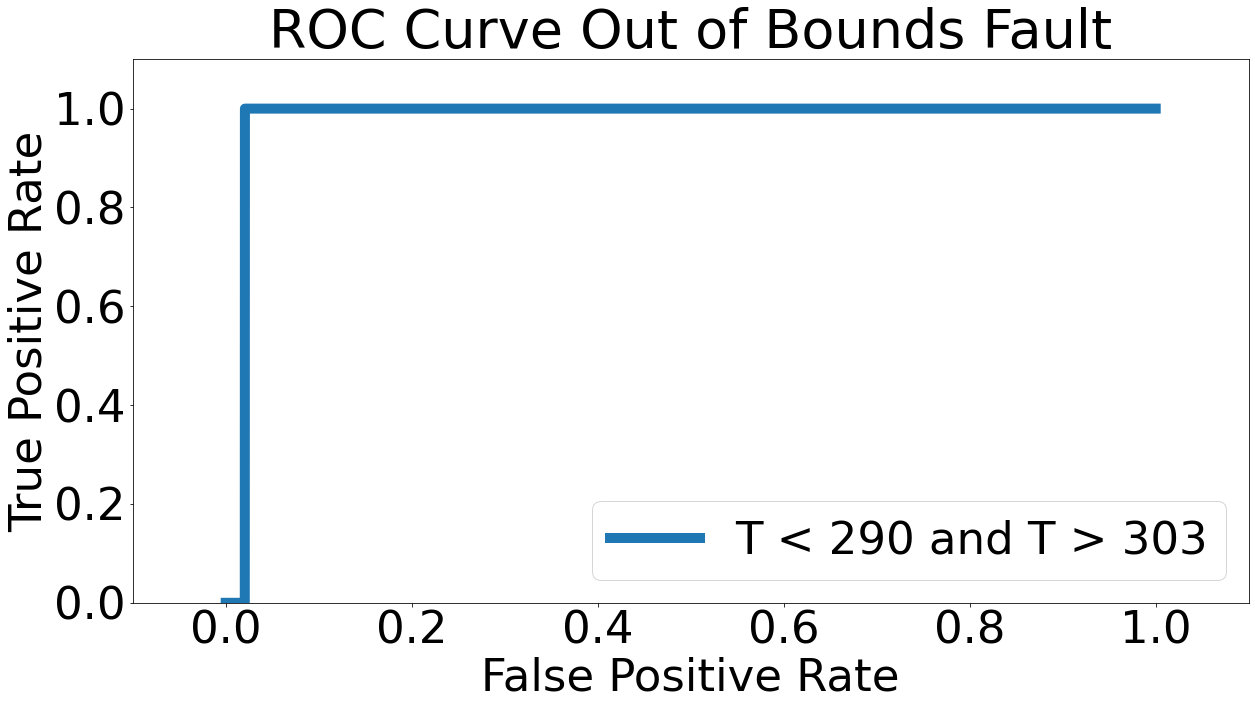

In [17]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr = dict()
tpr = dict()
roc_auc = dict()
y_score = clf.decision_function(x_test)
#y_prob = clf.predict_proba(x_test)
print(y_score)
# print(clf.score(x_train, y_train, sample_weight=None))
# print(probs)
#for i in range(2):
fpr, tpr, te_thresholds = roc_curve(y_test, y_score)

# print(fpr[0])
# print(tpr[0])

plt.rcParams.update({'font.size': 45})
plt.figure(figsize=(20,10))
#plt.plot(fpr[1], tpr[1])
plt.plot(fpr, tpr,linewidth = 10, label = "T < 290 and T > 303")
plt.xlim([-0.1, 1.1])
plt.ylim([0.0, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Out of Bounds Fault')
plt.legend(loc="lower right")
plt.show()

In [18]:
from sys import stdout
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
data.head()

,outdoor_temp,zone_temp,occupancy,supply_temp,air_flow
time,,,,,
2017-01-01 00:00:00,2.200,22.832449,0,25.000003,0.733767
2017-01-01 00:05:00,1.825,22.824465,0,25.000003,0.733767
2017-01-01 00:10:00,1.450,22.812760,0,25.000003,0.733767
2017-01-01 00:15:00,1.075,22.799019,0,25.000003,0.733767
2017-01-01 00:20:00,0.700,22.784421,0,25.000003,0.733767


In [19]:
def optimise_pls(X,y, n_comps):
    pls = PLSRegression(n_components= n_comps)
    #cross-validation with 10 fold 
    y_cv = cross_val_predict(pls,X,y, cv =10)
    
    #computing scores
    r2 = r2_score(y,y_cv)
    mse = mean_squared_error(y,y_cv)
    rdp = y.std()/np.sqrt(mse)
    
    return(y_cv, r2, mse, rdp)

In [20]:
r2s = []
mses = []
rpds = []
xticks = np.arange(1,7) # 40 components
for n_comp in xticks:
    y_cv, r2, mse, rpd = optimise_pls(scale(x_train), y_train, n_comp)
    r2s.append(r2)
    mses.append(mse)
    rpds.append(rpd)

In [21]:
def plot_metrics(vals, ylabel, objective):
    with plt.style.context('ggplot'):
        plt.plot(xticks, np.array(vals), '-v', color='blue', mfc='blue')
        if objective=='min':
            idx = np.argmin(vals)
        else:
            idx = np.argmax(vals)
        plt.plot(xticks[idx], np.array(vals)[idx], 'P', ms=10, mfc='red')

        plt.xlabel('Number of PLS components')
        plt.xticks = xticks
        plt.ylabel(ylabel)
        plt.title('PLS')

    plt.show()

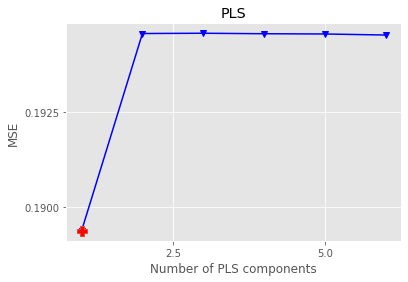

In [22]:
plot_metrics(mses, 'MSE', 'min')

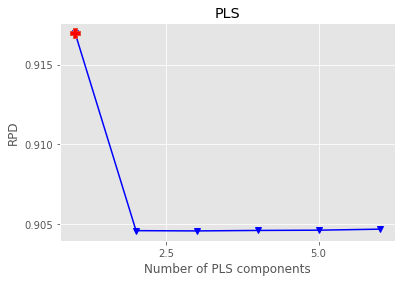

In [23]:
plot_metrics(rpds, 'RPD', 'max')

In [24]:
 y_cv, r2, mse, rpd = optimise_pls(scale(x_train), y_train, 1)

In [25]:
print('R2: %0.4f, MSE: %0.4f, RPD: %0.4f' %(r2, mse, rpd))

R2: -0.1893, MSE: 0.1894, RPD: 0.9170


In [72]:
pls = PLSRegression(n_components=1)
pls.fit(scale(x_train), y_train)
y_pred = pls.predict(scale(x_test))
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(rmse)
print('y_test: ',y_test)
print('y_pred: ',y_pred.T)

0.7220362796179979
y_test:  [1 1 1 ... 0 0 0]
y_pred:  [[1.24448891 1.24302535 1.27387004 ... 0.72670263 0.76985147 0.80325684]]


In [137]:

from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'xgboost'

In [208]:
scaler = preprocessing.StandardScaler().fit(x_train)
X_train_transformed = scaler.transform(x_train)
X_test_transformed = scaler.transform(x_test)
gbc=GradientBoostingClassifier(n_estimators=500,learning_rate=0.5,random_state=100,max_features=5)

In [209]:
gbc.fit(X_train_transformed, y_train)

GradientBoostingClassifier(learning_rate=0.5, max_features=5, n_estimators=500,
                           random_state=100)

In [210]:
GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=3,
                           max_features=5, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=500,
                           n_iter_no_change=None, presort='auto',
                           random_state=100, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

TypeError: __init__() got an unexpected keyword argument 'min_impurity_split'

In [211]:
print(confusion_matrix(y_test, gbc.predict(X_test_transformed)))
print(confusion_matrix(y_test, classification.predict(X_test_transformed)))

[[18202   718]
 [    0  2102]]


AttributeError: 'numpy.ndarray' object has no attribute 'predict'

In [212]:

y_pred = gbc.predict(X_test_transformed)

#scores = cross_val_score(clf, np.concatenate((x_train, x_test), axis=0), np.concatenate((y_train, y_test), axis=0), cv=5)
#print(scores)
#target_names = ['No Fault', 'Offset', 'Gain', 'Stuck','Out of Bounds']

target_names = ['No Fault', 'Fault']
#print('FOR rate: ',i)
cnf_matrix = confusion_matrix(y_test, y_pred)
#print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=target_names))
column_sum = cnf_matrix.sum(axis = 1)
#print(column_sum)
acc.append(cnf_matrix[1][1] / column_sum[1])
# offset.append(cnf_matrix[1][1] / column_sum[1] )
# gain.append(cnf_matrix[2][2] / column_sum[2])
# stuck.append(cnf_matrix[3][3] / column_sum[3])
# out_bounds.append(cnf_matrix[3][3] / column_sum[3])

#print(acc)
#i = i + 0.1 

              precision    recall  f1-score   support

    No Fault       1.00      0.96      0.98     18920
       Fault       0.75      1.00      0.85      2102

    accuracy                           0.97     21022
   macro avg       0.87      0.98      0.92     21022
weighted avg       0.97      0.97      0.97     21022



[ 23.56812007  25.77311649  30.05551098 ...  -6.9571636  -22.25799965
  -4.99730135]


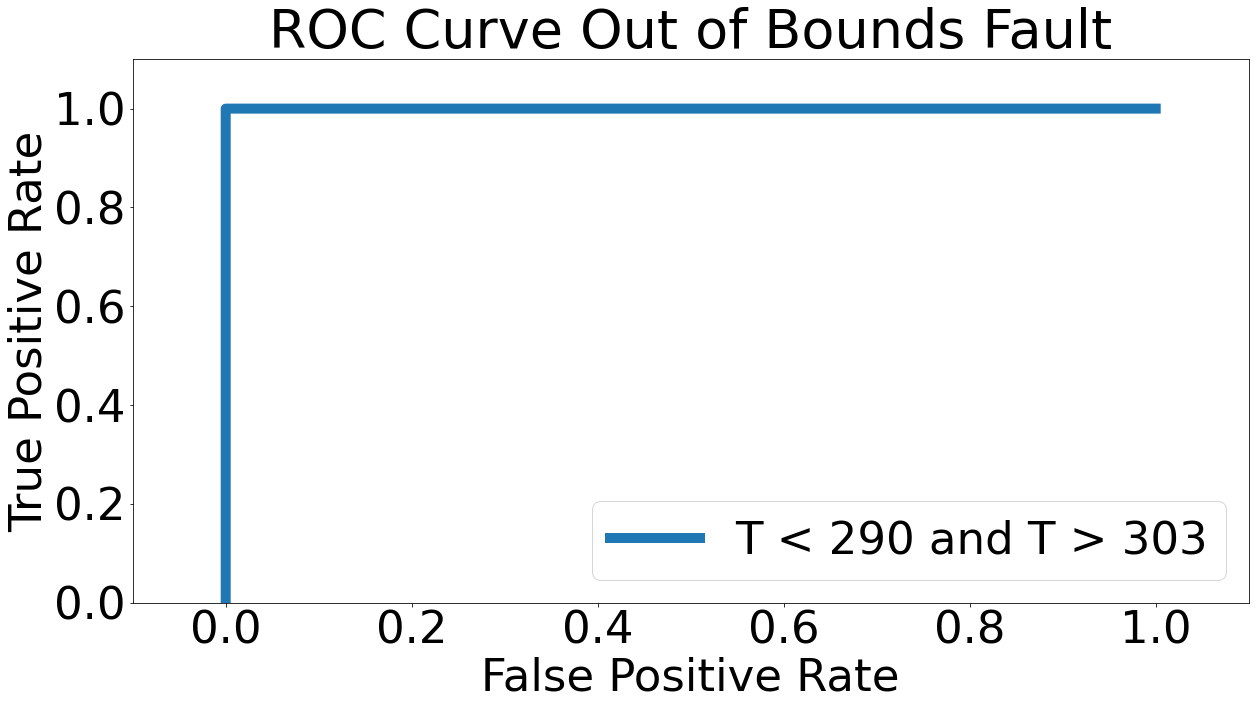

In [213]:
fpr = dict()
tpr = dict()
roc_auc = dict()
y_score = gbc.decision_function(X_test_transformed)
#y_prob = clf.predict_proba(x_test)
print(y_score)
# print(clf.score(x_train, y_train, sample_weight=None))
# print(probs)
#for i in range(2):
fpr, tpr, te_thresholds = roc_curve(y_test, y_score)

# print(fpr[0])
# print(tpr[0])

plt.rcParams.update({'font.size': 45})
plt.figure(figsize=(20,10))
#plt.plot(fpr[1], tpr[1])
plt.plot(fpr, tpr,linewidth = 10, label = "T < 290 and T > 303")
plt.xlim([-0.1, 1.1])
plt.ylim([0.0, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Out of Bounds Fault')
plt.legend(loc="lower right")
plt.show()

In [214]:
print("GBC accuracy is %2.2f" % accuracy_score(
    y_test, gbc.predict(X_test_transformed)))

GBC accuracy is 0.97


In [215]:
print("SVM accuracy is %2.2f" % accuracy_score(
    y_test, clf.predict(x_test)))

SVM accuracy is 0.51
